In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv
import scanpy as sc

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimBifur, SymsimTree, SymsimBranch, SymsimLinear, SymsimCycle

from symsimDatasetTest import SymsimTreeNoisy, SymsimBifurNoisy, SymsimLinearNoisy

from realDataset import forebrainDataset, chromaffinDataset

from unsupervised_loss import UnsupervisedLoss

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.autoencoder import AutoEncoder

from model.mymodel import MyModel, GraphSAGEModel, FCModel, veloModel, DiffusionModel


from math import sqrt
import scprep
import utils
import backbone

from torch_geometric.data import Data

In [2]:
dataBifur = SymsimBifur()
dataTree = SymsimTree()
# datalinear = SymsimLinear()
dataDyngen = RnaVeloDataset()
forebrain = forebrainDataset()
chromaffin = chromaffinDataset()

dataTreeNoisy = SymsimTreeNoisy()


Processing...
(1720, 1448)
(1720, 1448)
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Done!


In [3]:
t = np.arange(1,10)

# dataset for validation
val_mask = [10*i for i in range(4)]

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Path = "./Diffusion_symsim_tree_bifur_trifur_without_noise.pt"
# Path = "./Diffusion_symsim_tree_bifur_trifur.pt"

model = DiffusionModel(dataBifur.num_features, hidden1 = 128, hidden2 = 64, max_diffusion = 6, include_reversed = True, device = device, dropout1=0.4, dropout2=0.2).to(device)

model.load_state_dict(torch.load(Path, map_location=torch.device('cpu')))
model.eval()

DiffusionModel(
  (conv1): GraphDiffusion (300 -> 128)
  (conv2): GraphDiffusion (128 -> 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)

# Noiseless dataset

pearson corr: 0.724591122815461 , kendall tau: 0.6518436581525225
pearson corr: 0.6793486443536029 , kendall tau: 0.6617754301915841
pearson corr: 0.6210949981775868 , kendall tau: 0.6475026777823313
pearson corr: 0.7174191275599554 , kendall tau: 0.6158498533009463


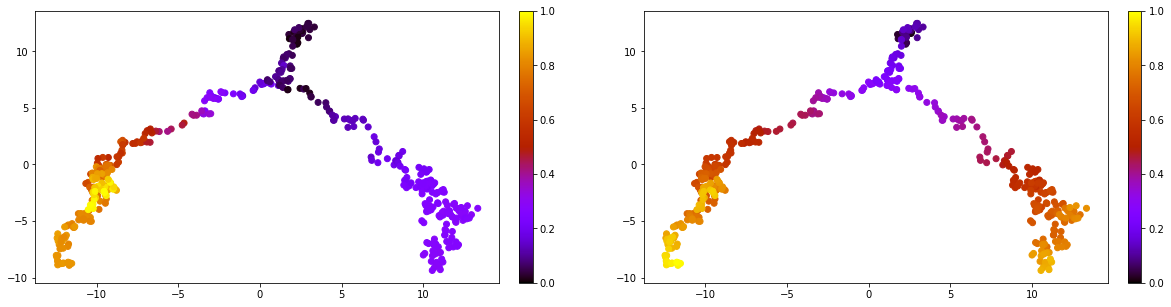

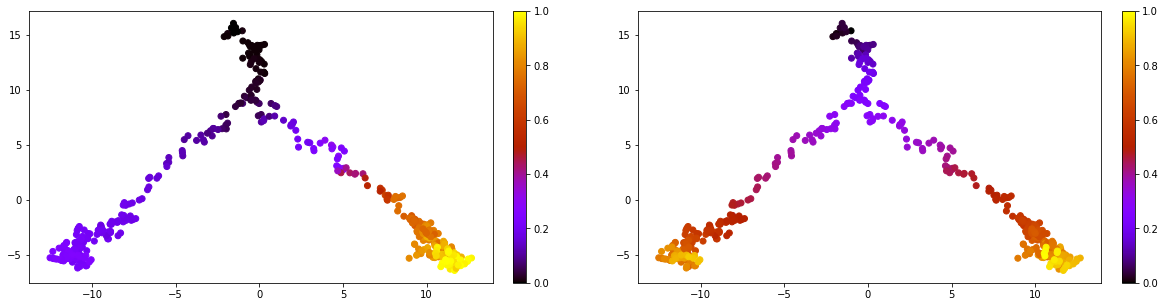

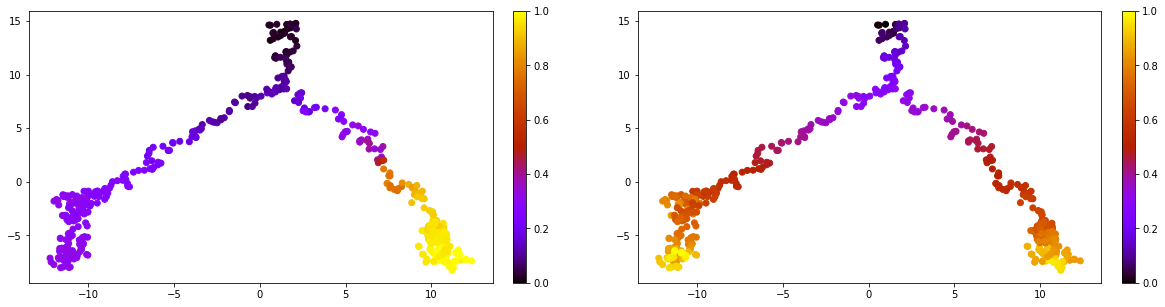

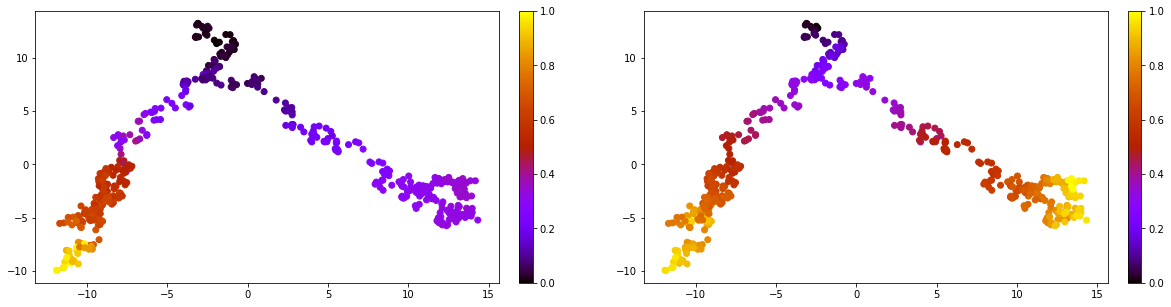

In [10]:
for idx, data in enumerate(DataLoader(dataTree[val_mask])):
    pt = data.y_vdpt[0]
    X_pca = utils.pca_op(data.x.detach().numpy())
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

pearson corr: 0.56944525 , kendall tau: 0.4185778895817165
pearson corr: 0.83726805 , kendall tau: 0.6186449864498645
pearson corr: 0.94300836 , kendall tau: 0.7853897579022522
pearson corr: 0.8941789 , kendall tau: 0.6655957471397203


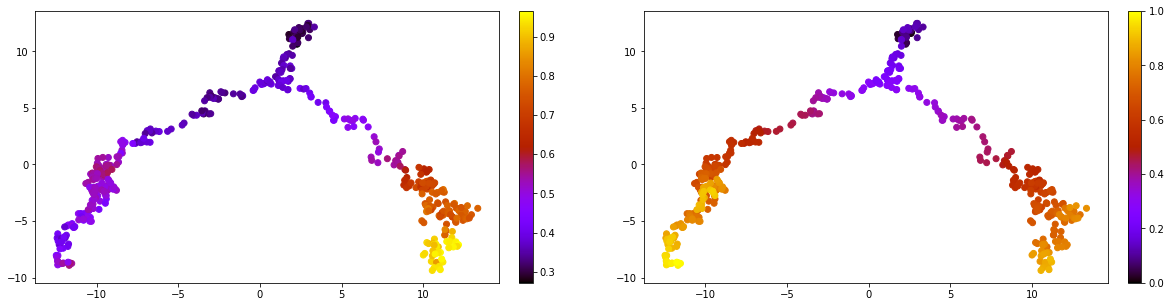

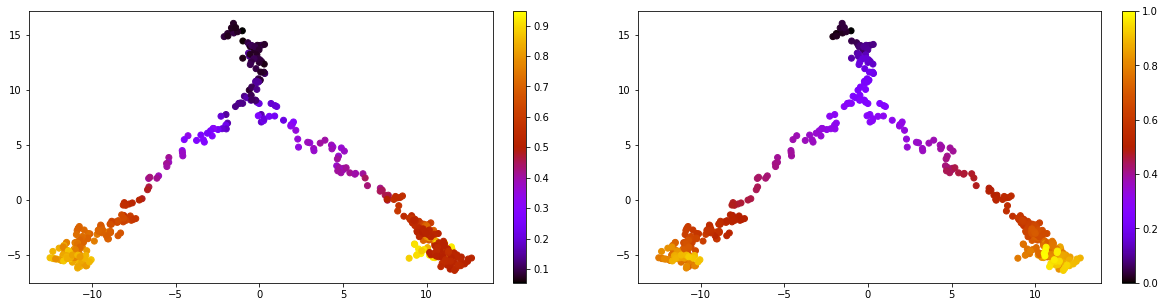

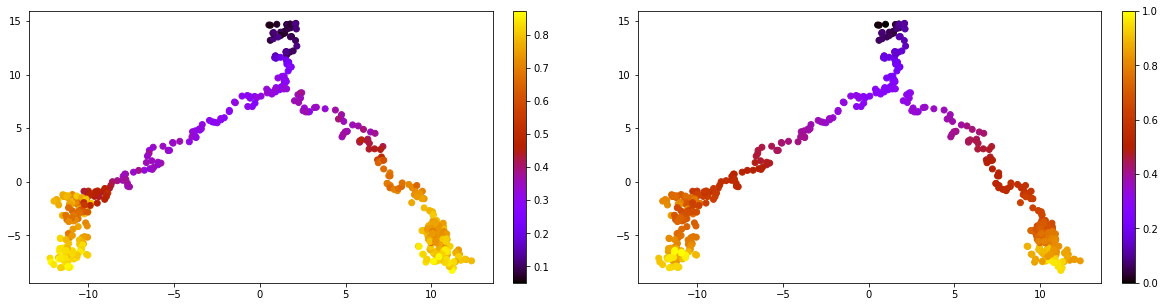

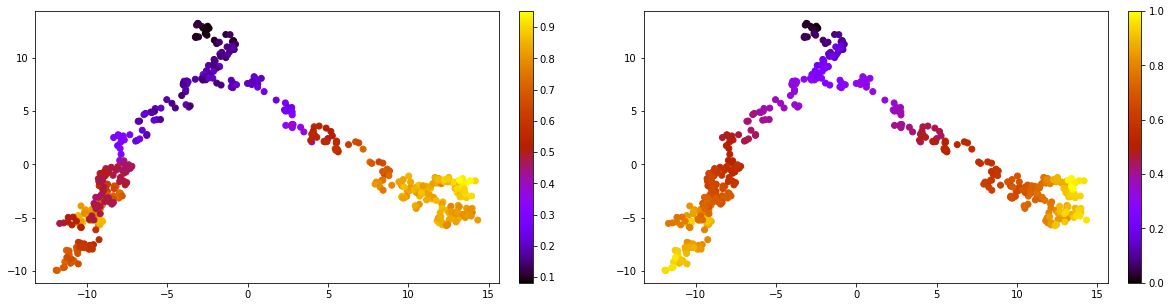

In [11]:
for idx, data in enumerate(DataLoader(dataTree[val_mask])):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)

    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().cpu().numpy().reshape(-1)
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

# Noisy dataset

pearson corr: -0.05474083999941431 , kendall tau: 0.018638621092608824
pearson corr: 0.008779502635782385 , kendall tau: -0.011543758607737573
pearson corr: -0.07238964843001418 , kendall tau: 0.001343850423605025
pearson corr: -0.08985786013552625 , kendall tau: -0.25475564458912403


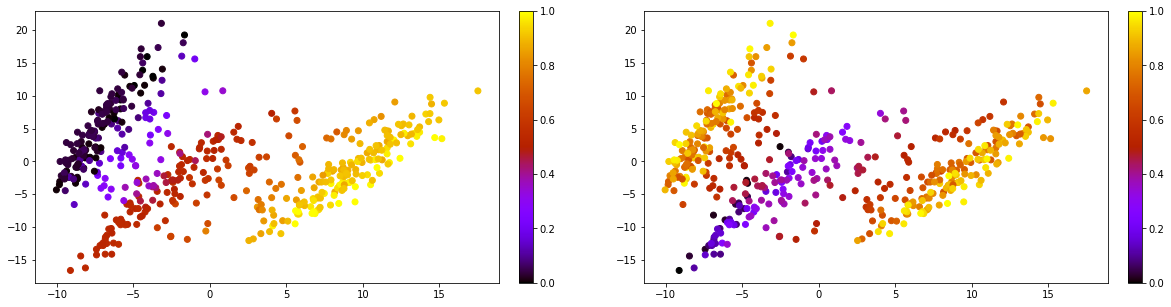

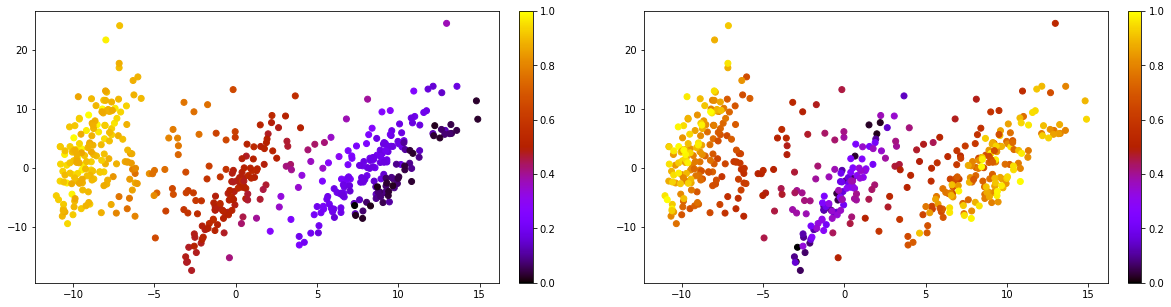

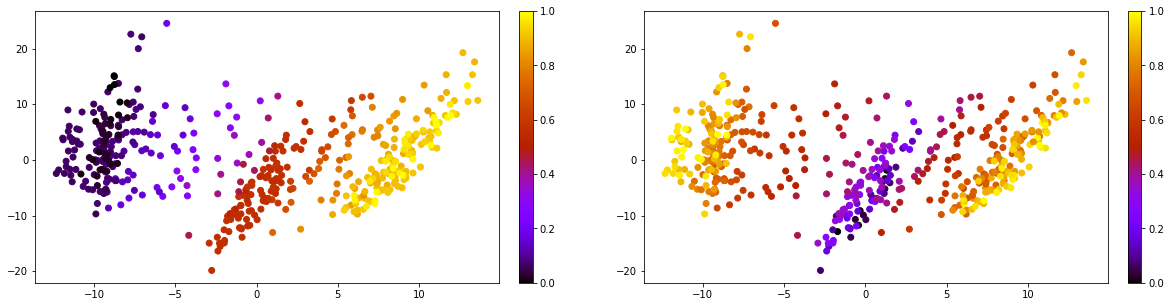

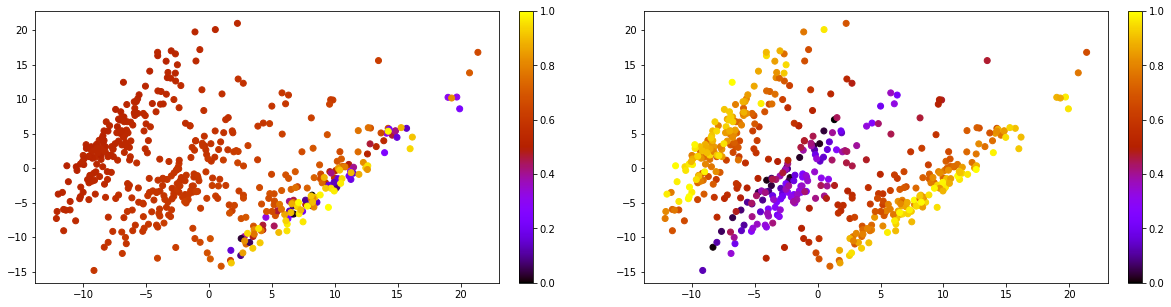

In [12]:
for idx, data in enumerate(DataLoader(dataTreeNoisy[val_mask])):
    pt = data.y_vdpt[0]
    X_pca = utils.pca_op(data.x.detach().numpy())
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

pearson corr: 0.7925656 , kendall tau: 0.511506197571053
pearson corr: 0.7780959 , kendall tau: 0.5526563999833063
pearson corr: 0.6237149 , kendall tau: 0.4106589875213889
pearson corr: 0.5761498 , kendall tau: 0.3993906765160052


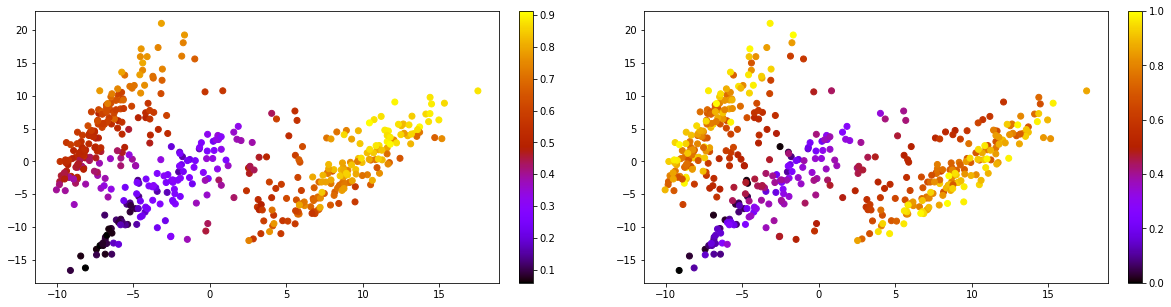

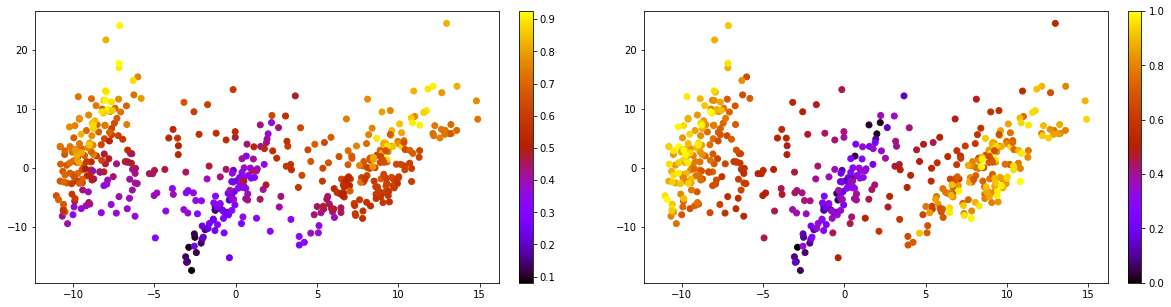

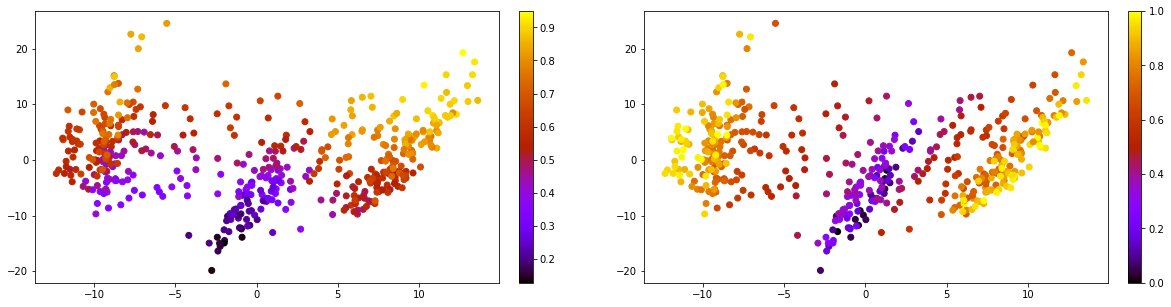

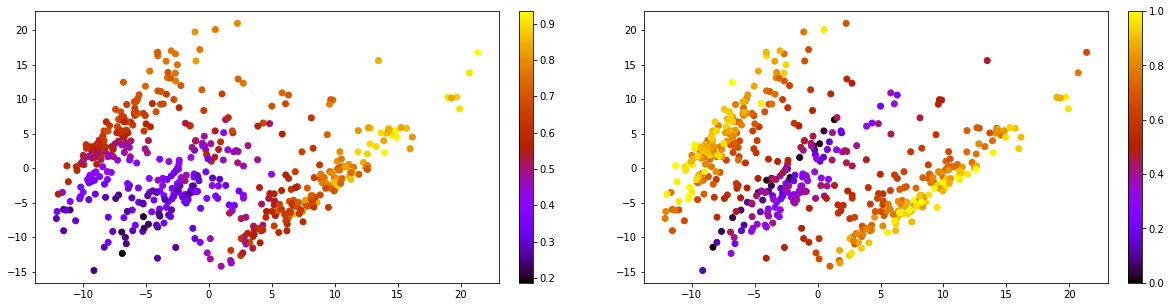

In [13]:
for idx, data in enumerate(DataLoader(dataTreeNoisy[val_mask])):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)

    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().cpu().numpy().reshape(-1)
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

# Dyngen dataset

pearson corr: -0.91206217 , kendall tau: -0.8386952049847717
pearson corr: -0.941813 , kendall tau: -0.8661298208798085
pearson corr: -0.8425501 , kendall tau: -0.7113436066373354
pearson corr: -0.9385217 , kendall tau: -0.8765218801467162
pearson corr: -0.90526354 , kendall tau: -0.8053790864939491
pearson corr: -0.9136029 , kendall tau: -0.8386841784239223
pearson corr: -0.890155 , kendall tau: -0.742666554301784
pearson corr: -0.93152267 , kendall tau: -0.8206683727774483
pearson corr: -0.92238986 , kendall tau: -0.8503322024689421
pearson corr: -0.90452856 , kendall tau: -0.8242977073449818
pearson corr: -0.9121106 , kendall tau: -0.803352719788275


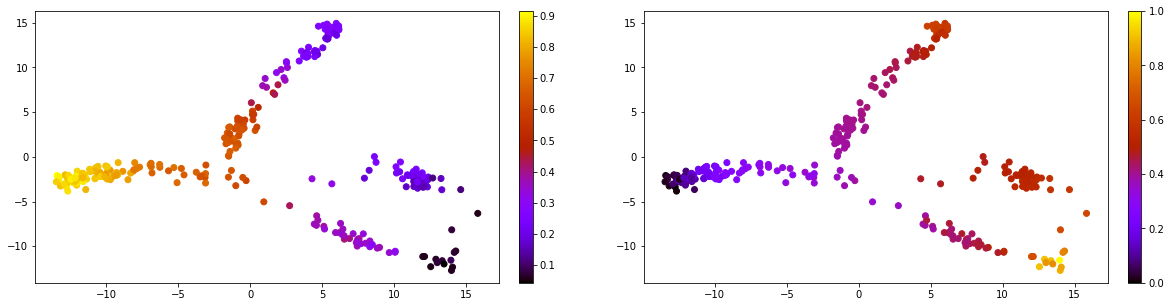

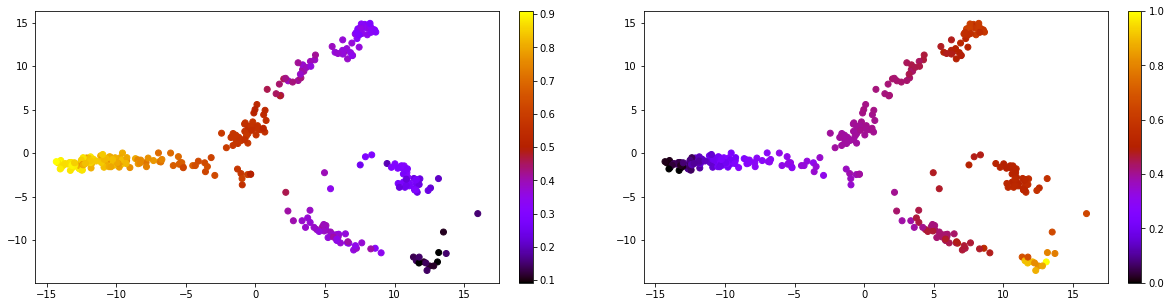

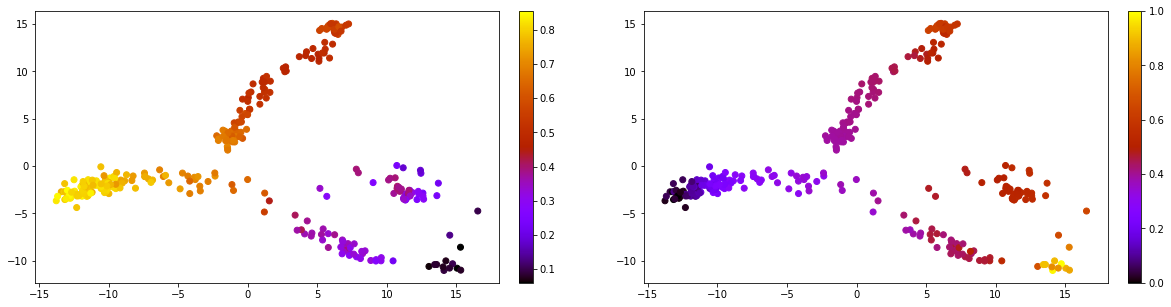

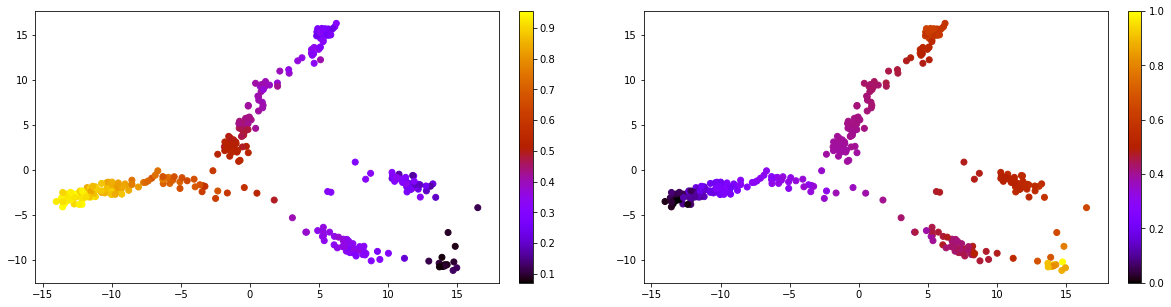

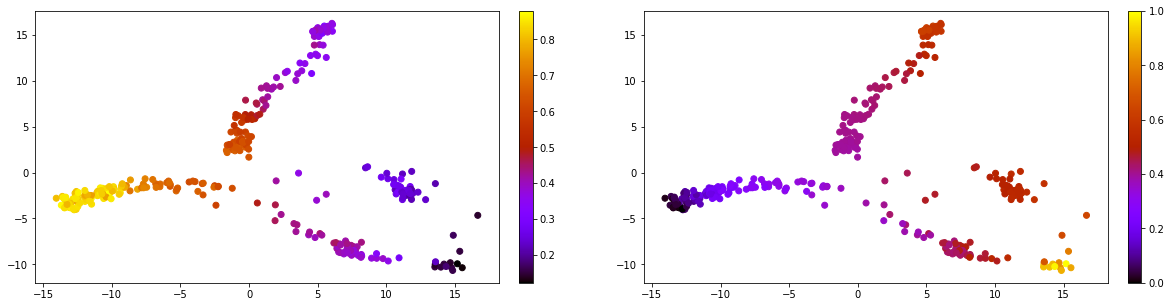

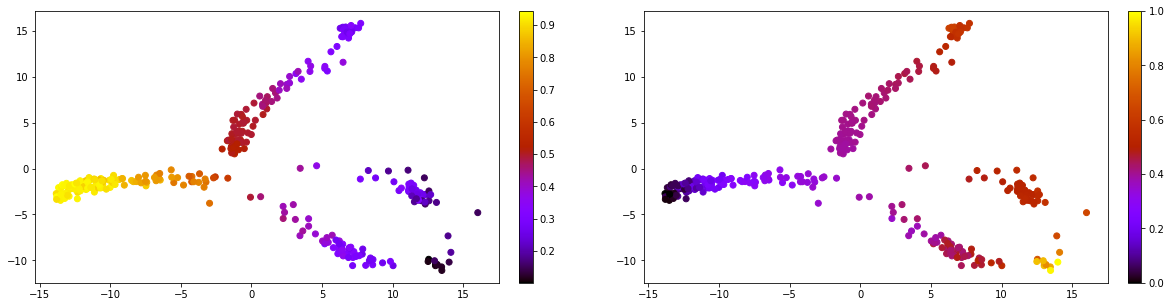

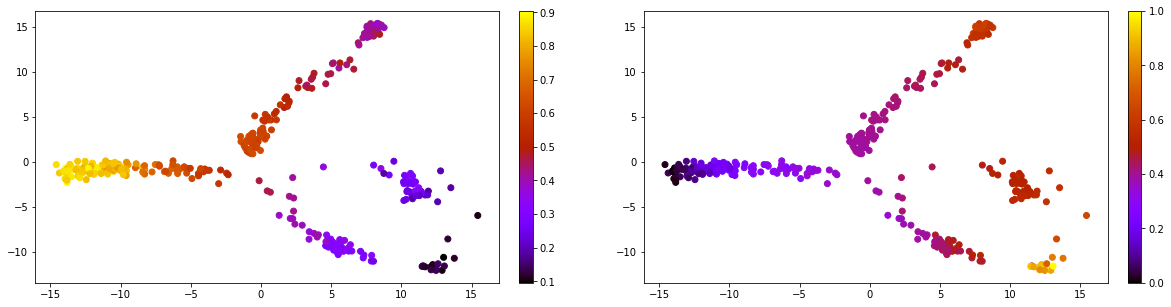

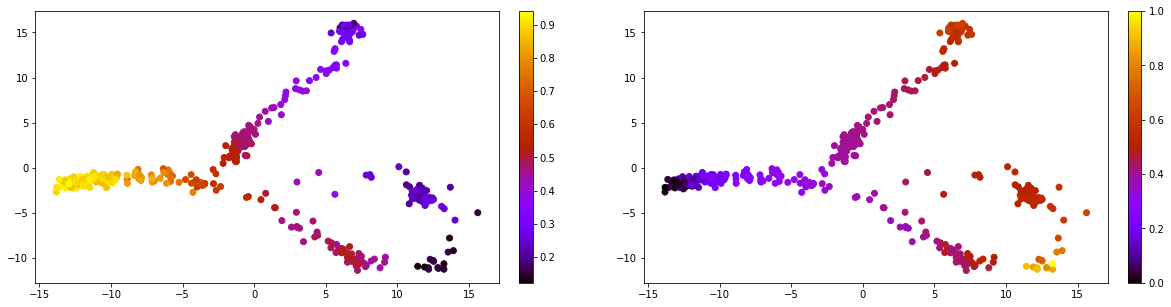

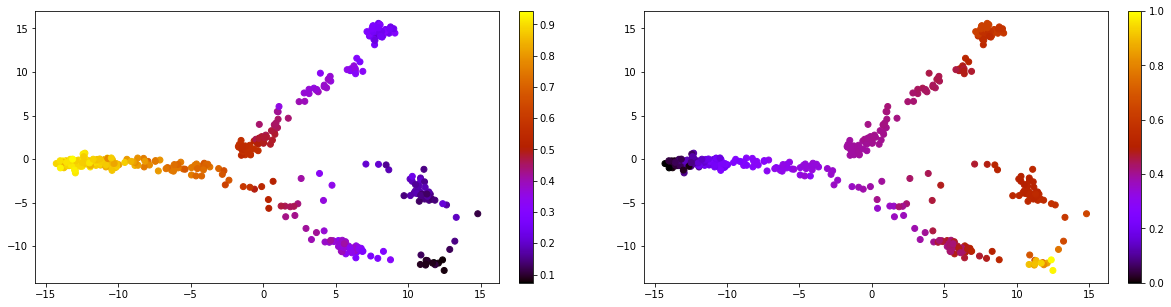

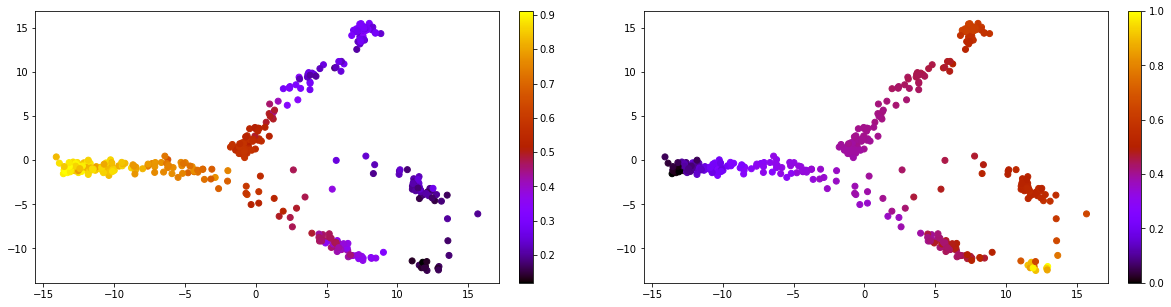

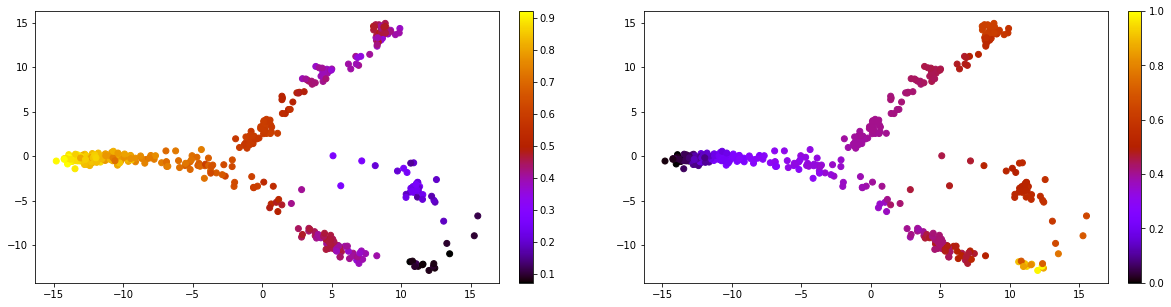

In [14]:
for idx, data in enumerate(DataLoader(dataDyngen)):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    
    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().cpu().numpy().reshape(-1)
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

# Real dataset

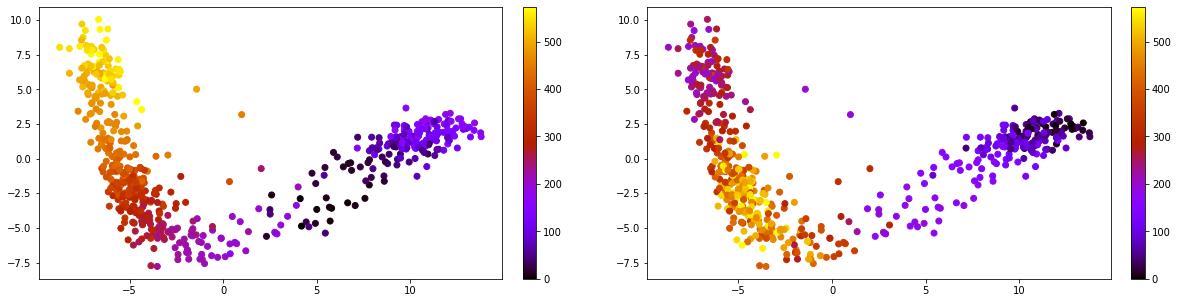

In [30]:
for idx, data in enumerate(DataLoader(forebrain)):
    pt = data.y_vdpt[0].squeeze()

    # pt = np.argsort(pt)
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    fig = plt.figure(figsize = (20, 5))
    ax1,ax2 = fig.subplots(1,2)
    
    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]

    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().numpy().squeeze()

    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]
    # pt = (pt - np.min(pt))/(np.max(pt)-np.min(pt))
    # print(len(pt))
    # pt = np.argsort(pt)
    
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)    

    

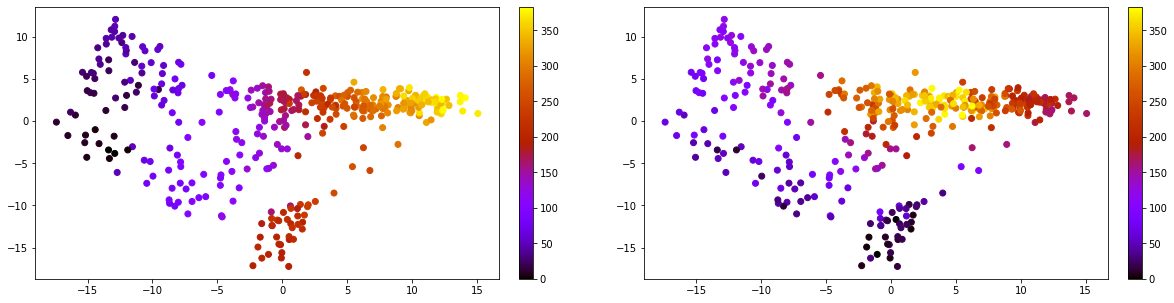

In [35]:
for idx, data in enumerate(DataLoader(chromaffin)):
    pt = data.y_vdpt[0].squeeze()

    # pt = np.argsort(pt)
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    fig = plt.figure(figsize = (20, 5))
    ax1,ax2 = fig.subplots(1,2)
    
    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]

    pseudo_visual = ax1.scatter(-X_pca[:,0], -X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().numpy().squeeze()

    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]
    # pt = (pt - np.min(pt))/(np.max(pt)-np.min(pt))
    # print(len(pt))
    # pt = np.argsort(pt)
    
    pseudo_visual = ax2.scatter(-X_pca[:,0], -X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)  

In [67]:
adata = anndata.read_h5ad('./data/real_dataset/chromaffin.h5ad')

scv.pp.filter_and_normalize(adata, flavor = 'cell_ranger', min_shared_counts=20, n_top_genes=301, log=True)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata, mode='stochastic') 
scv.tl.velocity_graph(adata)

Filtered out 9895 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


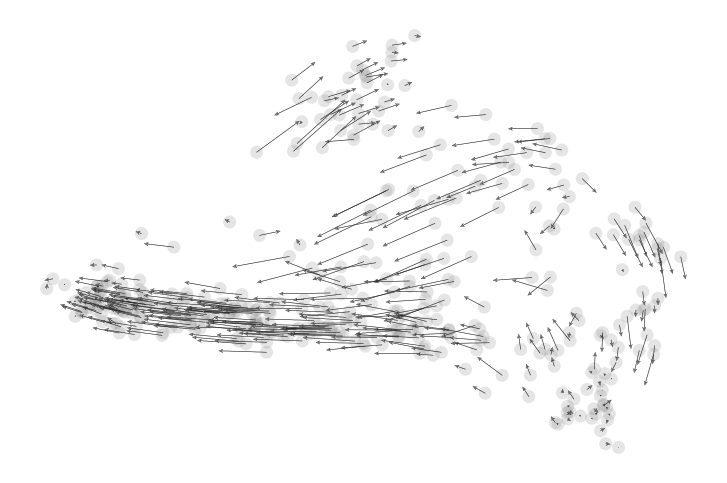

In [68]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding(adata, dpi = 150, basis='pca', arrow_length= 10)

In [ ]:
def filter_genes_dispersion(data, flavor='seurat', min_disp=None, max_disp=None, min_mean=None, max_mean=None,
                            n_bins=20, n_top_genes=None, log=True, copy=False):
    """Extract highly variable genes.
    The normalized dispersion is obtained by scaling with the mean and standard
    deviation of the dispersions for genes falling into a given bin for mean
    expression of genes. This means that for each bin of mean expression, highly
    variable genes are selected.

    Parameters
    ----------
    data : :class:`~anndata.AnnData`, `np.ndarray`, `sp.sparse`
        The (annotated) data matrix of shape `n_obs` × `n_vars`. Rows correspond
        to cells and columns to genes.
    flavor : {'seurat', 'cell_ranger', 'svr'}, optional (default: 'seurat')
        Choose the flavor for computing normalized dispersion. If choosing
        'seurat', this expects non-logarithmized data - the logarithm of mean
        and dispersion is taken internally when `log` is at its default value
        `True`. For 'cell_ranger', this is usually called for logarithmized data
        - in this case you should set `log` to `False`. In their default
        workflows, Seurat passes the cutoffs whereas Cell Ranger passes
        `n_top_genes`.
    min_mean=0.0125, max_mean=3, min_disp=0.5, max_disp=`None` : `float`, optional
        If `n_top_genes` unequals `None`, these cutoffs for the means and the
        normalized dispersions are ignored.
    n_bins : `int` (default: 20)
        Number of bins for binning the mean gene expression. Normalization is
        done with respect to each bin. If just a single gene falls into a bin,
        the normalized dispersion is artificially set to 1. You'll be informed
        about this if you set `settings.verbosity = 4`.
    n_top_genes : `int` or `None` (default: `None`)
        Number of highly-variable genes to keep.
    log : `bool`, optional (default: `True`)
        Use the logarithm of the mean to variance ratio.
    copy : `bool`, optional (default: `False`)
        If an :class:`~anndata.AnnData` is passed, determines whether a copy
        is returned.

    Returns
    -------
    If an AnnData `adata` is passed, returns or updates `adata` depending on \
    `copy`. It filters the `adata` and adds the annotations
    """
    adata = data.copy() if copy else data
    set_initial_size(adata)
    if n_top_genes is not None and adata.n_vars < n_top_genes:
        logg.info('Skip filtering by dispersion since number of variables are less than `n_top_genes`')
    else:
        if flavor == 'svr':
            mu = adata.X.mean(0).A1 if issparse(adata.X) else adata.X.mean(0)
            sigma = np.sqrt(adata.X.multiply(adata.X).mean(0).A1 - mu ** 2) if issparse(adata.X) else adata.X.std(0)
            log_mu = np.log2(mu)
            log_cv = np.log2(sigma / mu)

            from sklearn.svm import SVR
            clf = SVR(gamma=150. / len(mu))
            clf.fit(log_mu[:, None], log_cv)
            score = log_cv - clf.predict(log_mu[:, None])
            nth_score = np.sort(score)[::-1][n_top_genes]
            adata._inplace_subset_var(score >= nth_score)
        else:
            from scanpy.preprocessing import filter_genes_dispersion
            filter_genes_dispersion(adata, flavor=flavor, min_disp=min_disp, max_disp=max_disp, min_mean=min_mean,
                                    max_mean=max_mean, n_bins=n_bins, n_top_genes=n_top_genes, log=log)
    return adata if copy else None


In [ ]:
def highly_variable_genes(
    adata: AnnData,
    min_disp: Optional[float] = None,
    max_disp: Optional[float] = None,
    min_mean: Optional[float] = None,
    max_mean: Optional[float] = None,
    n_top_genes: Optional[int] = None,
    n_bins: int = 20,
    flavor: Literal['seurat', 'cell_ranger'] = 'seurat',
    subset: bool = False,
    inplace: bool = True,
    batch_key: Optional[str] = None,
) -> Optional[np.recarray]:
    """\
    Annotate highly variable genes [Satija15]_ [Zheng17]_.

    Expects logarithmized data.

    Depending on `flavor`, this reproduces the R-implementations of Seurat
    [Satija15]_ and Cell Ranger [Zheng17]_.

    The normalized dispersion is obtained by scaling with the mean and standard
    deviation of the dispersions for genes falling into a given bin for mean
    expression of genes. This means that for each bin of mean expression, highly
    variable genes are selected.

    Parameters
    ----------
    adata
        The annotated data matrix of shape `n_obs` × `n_vars`. Rows correspond
        to cells and columns to genes.
    min_mean
        If `n_top_genes` unequals `None`, this and all other cutoffs for the means and the
        normalized dispersions are ignored.
    max_mean
        If `n_top_genes` unequals `None`, this and all other cutoffs for the means and the
        normalized dispersions are ignored.
    min_disp
        If `n_top_genes` unequals `None`, this and all other cutoffs for the means and the
        normalized dispersions are ignored.
    max_disp
        If `n_top_genes` unequals `None`, this and all other cutoffs for the means and the
        normalized dispersions are ignored.
    n_top_genes
        Number of highly-variable genes to keep.
    n_bins
        Number of bins for binning the mean gene expression. Normalization is
        done with respect to each bin. If just a single gene falls into a bin,
        the normalized dispersion is artificially set to 1. You'll be informed
        about this if you set `settings.verbosity = 4`.
    flavor
        Choose the flavor for computing normalized dispersion. In their default
        workflows, Seurat passes the cutoffs whereas Cell Ranger passes
        `n_top_genes`.
    subset
        Inplace subset to highly-variable genes if `True` otherwise merely indicate
        highly variable genes.
    inplace
        Whether to place calculated metrics in `.var` or return them.
    batch_key
        If specified, highly-variable genes are selected within each batch separately and merged.
        This simple process avoids the selection of batch-specific genes and acts as a
        lightweight batch correction method.

    Returns
    -------
    Depending on `inplace` returns calculated metrics (:class:`~numpy.recarray`) or
    updates `.var` with the following fields

    highly_variable : bool
        boolean indicator of highly-variable genes
    **means**
        means per gene
    **dispersions**
        dispersions per gene
    **dispersions_norm**
        normalized dispersions per gene
    highly_variable_nbatches : int
        If batch_key is given, this denotes in how many batches genes are detected as HVG
    highly_variable_intersection : bool
        If batch_key is given, this denotes the genes that are highly variable in all batches

    Notes
    -----
    This function replaces :func:`~scanpy.pp.filter_genes_dispersion`.
    """

    start = logg.info('extracting highly variable genes')

    if not isinstance(adata, AnnData):
        raise ValueError(
            '`pp.highly_variable_genes` expects an `AnnData` argument, '
            'pass `inplace=False` if you want to return a `np.recarray`.')

    if batch_key is None:
        df = _highly_variable_genes_single_batch(
            adata,
            min_disp=min_disp, max_disp=max_disp,
            min_mean=min_mean, max_mean=max_mean,
            n_top_genes=n_top_genes,
            n_bins=n_bins,
            flavor=flavor,
        )
    else:
        sanitize_anndata(adata)
        batches = adata.obs[batch_key].cat.categories
        df = []
        gene_list = adata.var_names
        for batch in batches:
            adata_subset = adata[adata.obs[batch_key] == batch]

            # Filter to genes that are in the dataset
            with settings.verbosity.override(Verbosity.error):
                filt = filter_genes(adata_subset, min_cells=1, inplace=False)[0]

            adata_subset = adata_subset[:,filt]

            hvg = _highly_variable_genes_single_batch(
                adata_subset,
                min_disp=min_disp, max_disp=max_disp,
                min_mean=min_mean, max_mean=max_mean,
                n_top_genes=n_top_genes,
                n_bins=n_bins,
                flavor=flavor,
            )

            # Add 0 values for genes that were filtered out
            missing_hvg = pd.DataFrame(
                np.zeros((np.sum(~filt), len(hvg.columns))),
                columns=hvg.columns,
            )
            missing_hvg['highly_variable'] = missing_hvg['highly_variable'].astype(bool)
            missing_hvg['gene'] = gene_list[~filt]
            hvg['gene'] = adata_subset.var_names.values
            hvg = hvg.append(missing_hvg, ignore_index=True)

            # Order as before filtering
            idxs = np.concatenate((np.where(filt)[0], np.where(~filt)[0]))
            hvg = hvg.loc[np.argsort(idxs)]

            df.append(hvg)

        df = pd.concat(df, axis=0)
        df['highly_variable'] = df['highly_variable'].astype(int)
        df = df.groupby('gene').agg(dict(
            means=np.nanmean,
            dispersions=np.nanmean,
            dispersions_norm=np.nanmean,
            highly_variable=np.nansum,
        ))
        df.rename(columns=dict(highly_variable='highly_variable_nbatches'), inplace=True)
        df['highly_variable_intersection'] = df['highly_variable_nbatches'] == len(batches)

        if n_top_genes is not None:
            # sort genes by how often they selected as hvg within each batch and
            # break ties with normalized dispersion across batches
            df.sort_values(
                ['highly_variable_nbatches', 'dispersions_norm'],
                ascending=False, na_position='last', inplace=True,
            )
            df['highly_variable'] = False
            df.loc[:n_top_genes, 'highly_variable'] = True
            df = df.loc[adata.var_names]
        else:
            df = df.loc[adata.var_names]
            dispersion_norm = df.dispersions_norm.values
            dispersion_norm[np.isnan(dispersion_norm)] = 0  # similar to Seurat
            gene_subset = np.logical_and.reduce((
                df.means > min_mean, df.means < max_mean,
                df.dispersions_norm > min_disp,
                df.dispersions_norm < max_disp,
            ))
            df['highly_variable'] = gene_subset

    logg.info('    finished', time=start)

    if inplace or subset:
        logg.hint(
            'added\n'
            '    \'highly_variable\', boolean vector (adata.var)\n'
            '    \'means\', float vector (adata.var)\n'
            '    \'dispersions\', float vector (adata.var)\n'
            '    \'dispersions_norm\', float vector (adata.var)'
        )
        adata.var['highly_variable'] = df['highly_variable'].values
        adata.var['means'] = df['means'].values
        adata.var['dispersions'] = df['dispersions'].values
        adata.var['dispersions_norm'] = df['dispersions_norm'].values.astype('float32', copy=False)
        if batch_key is not None:
            adata.var['highly_variable_nbatches'] = df['highly_variable_nbatches'].values
            adata.var['highly_variable_intersection'] = df['highly_variable_intersection'].values
        if subset:
            adata._inplace_subset_var(df['highly_variable'].values)
    else:
        arrays = [
             df['highly_variable'].values,
             df['means'].values,
             df['dispersions'].values,
             df['dispersions_norm'].values.astype('float32', copy=False),
        ]
        dtypes = [
            ('highly_variable', np.bool_),
            ('means', 'float32'),
            ('dispersions', 'float32'),
            ('dispersions_norm', 'float32'),
        ]
        if batch_key is not None:
            arrays.extend([
                df['highly_variable_nbatches'].values,
                df['highly_variable_intersection'].values,
            ])
            dtypes.append([
                ('highly_variable_nbatches', int),
                ('highly_variable_intersection', np.bool_),
            ])
        return np.rec.fromarrays(arrays, dtype=dtypes)
